In [1]:
import numpy as np
import roboticstoolbox as rtb
from spatialmath import *
from math import pi
import matplotlib.pyplot as plt
from matplotlib import cm
np.set_printoptions(linewidth=100, formatter={'float': lambda x: f"{x:8.4g}" if x > 1e-10 else f"{0:8.4g}"})

%matplotlib notebook

The Toolbox supports models defined using a number of different conventions.  We will load a very classical model, a Puma560 robot defined in terms of standard Denavit-Hartenberg parameters

In [2]:
p560 = rtb.models.DH.Puma560()

Now we can display the simple Denavit-Hartenberg parameter model

In [3]:
print(p560)


Puma 560 (Unimation): 6 axis, RRRRRR, std DH
Parameters:
Revolute   theta=q1 + 0.00,  d= 0.00,  a= 0.00,  alpha= 1.57
Revolute   theta=q2 + 0.00,  d= 0.00,  a= 0.43,  alpha= 0.00
Revolute   theta=q3 + 0.00,  d= 0.15,  a= 0.02,  alpha=-1.57
Revolute   theta=q4 + 0.00,  d= 0.43,  a= 0.00,  alpha= 1.57
Revolute   theta=q5 + 0.00,  d= 0.00,  a= 0.00,  alpha=-1.57
Revolute   theta=q6 + 0.00,  d= 0.00,  a= 0.00,  alpha= 0.00

tool:  t = (0, 0, 0),  RPY/xyz = (0, 0, 0) deg


which indicates that the robot has no tool transform. The second column indicates that the Denavit-Hartenberg joint rotation is the Toolbox joint angle with an offset of zero, ie. in this case they are identical.

This object is a subclass of `DHRobot`, equivalent to the `SerialLink` class in the MATLAB version of the Toolbox.

This class has many methods and attributes.  One useful set of attributes are named joint configurations, for example the canonical ready position

In [4]:
p560.qr

array([       0,    1.571,        0,        0,        0,        0])

the zero angle configuration

In [5]:
p560.qz

array([0, 0, 0, 0, 0, 0])

and a nominal desktop working configuration

In [6]:
p560.qn

array([       0,   0.7854,    3.142,        0,   0.7854,        0])

and we can display the robot, in this configuration, graphically

<IPython.core.display.Javascript object>


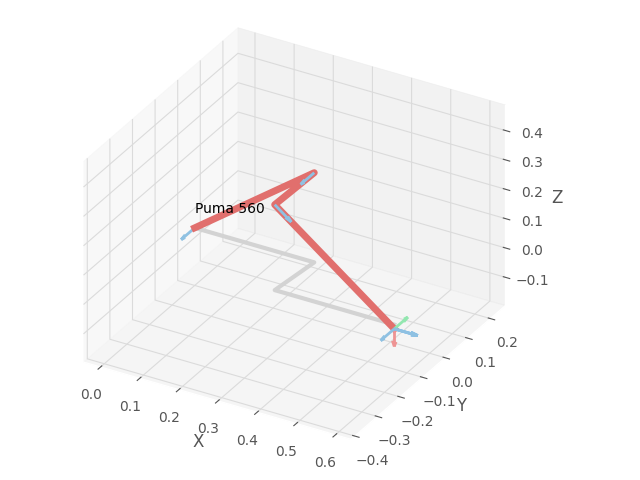

In [7]:
p560.plot(p560.qn, block=True)

and the end-effector pose is given by the forward kinematics

In [8]:
p560.fkine(p560.qr)

   1           0           0           0.0203       
   0           1           0          -0.15005      
   0           0           1           0.8636       
   0           0           0           1            



which is a 4x4 SE(3) matrix displayed in a color coded way with rotation matrix in red, translation vector in blue, and constant elements in grey.  This is an instance of an `SE3` object safely encapsulates the SE(3) matrix.  This class, and related ones, are implemented by the [Spatial Math Toolbox for Python](https://github.com/petercorke/spatialmath-python).

We can manually adjust the joint angles of this robot (click and drag the sliders) to see how the shape of the robot changes and how the end-effector pose changes

<IPython.core.display.Javascript object>


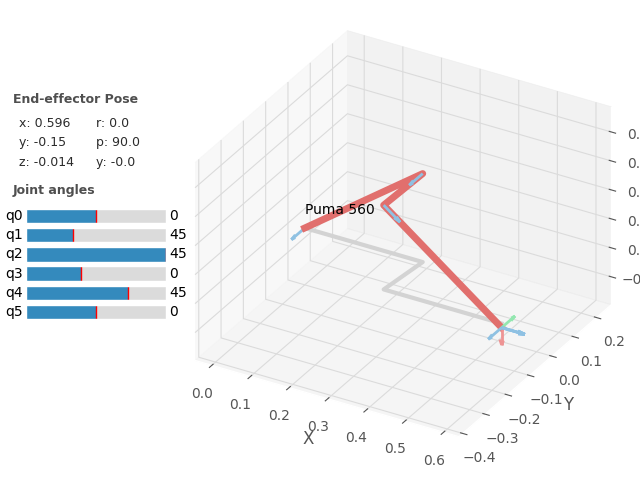

In [9]:
p560.teach(block=True)

An important problem in robotics is _inverse kinematics_, determining the joint angles to put the robot's end effector at a particular pose.

Suppose we want the end-effector to be at position (0.5, 0.2, 0.1) and to have its gripper pointing (its _approach vector_) in the x-direction, and its fingers one above the other so that its _orientation vector_ is parallel to the z-axis.

We can specify that pose by composing two SE(3) matrices:

1. a pure translation
2. a pure rotation defined in terms of the orientation and approach vectors

In [10]:
T = SE3(0.5, 0.2, -0.1) * SE3.OA([0,0,1], [1,0,0])
T

   0           0           1           0.5          
   1           0           0           0.2          
   0           1           0          -0.1          
   0           0           0           1            



Now we can compute the joint angles that results in this pose

In [11]:
(q, failed, reason) = p560.ikine(T)

which returns the joint coordinates as well as failure status

In [12]:
failed

False

indicating, in this case, that there is no failure. The joint coordinates are

In [13]:
q

array([  0.6629,        0,   0.3066,        0,        0,    2.136])

and we can confirm that this is indeed an inverse kinematic solution by computing the forward kinematics

In [14]:
p560.fkine(q)

   0           0           1           0.5          
   1           0           0           0.2          
   0           1           0          -0.1          
   0           0           0           1            



which matches the original transform.

A simple trajectory between two joint configuration is

In [15]:
qt = rtb.tools.trajectory.jtraj(p560.qz, q, 50)

The result is a _namedtuple_ with attributes `q` containing the joint angles, as well as `qd`, `qdd` and `t` which hold the joint velocity, joint accelerations and time respectively.  

The joint angles are a matrix with one column per joint and one row per timestep, and time increasing with row number.

In [16]:
qt.q

array([[       0,        0,        0,        0,        0,        0],
       [5.463e-05,        0, 2.527e-05,        0,        0, 0.000176],
       [0.0004236,        0, 0.0001959,        0,        0, 0.001365],
       [0.001385,        0, 0.0006406,        0,        0, 0.004463],
       [0.003179,        0,  0.00147,        0,        0,  0.01024],
       [0.006009,        0, 0.002779,        0,        0,  0.01936],
       [ 0.01004,        0, 0.004646,        0,        0,  0.03236],
       [ 0.01542,        0, 0.007132,        0,        0,  0.04969],
       [ 0.02224,        0,  0.01029,        0,        0,  0.07167],
       [ 0.03059,        0,  0.01415,        0,        0,  0.09856],
       [  0.0405,        0,  0.01873,        0,        0,   0.1305],
       [ 0.05201,        0,  0.02405,        0,        0,   0.1676],
       [  0.0651,        0,  0.03011,        0,        0,   0.2098],
       [ 0.07975,        0,  0.03689,        0,        0,    0.257],
       [ 0.09592,        0,  

We can plot this trajectory as a function of time using the convenience function `qplot`

<IPython.core.display.Javascript object>


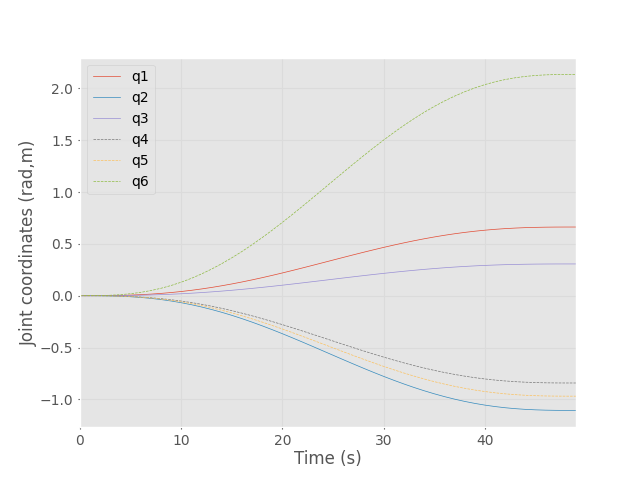

In [17]:
rtb.tools.trajectory.qplot(qt.q, block=True)

and then we can animate this

<IPython.core.display.Javascript object>


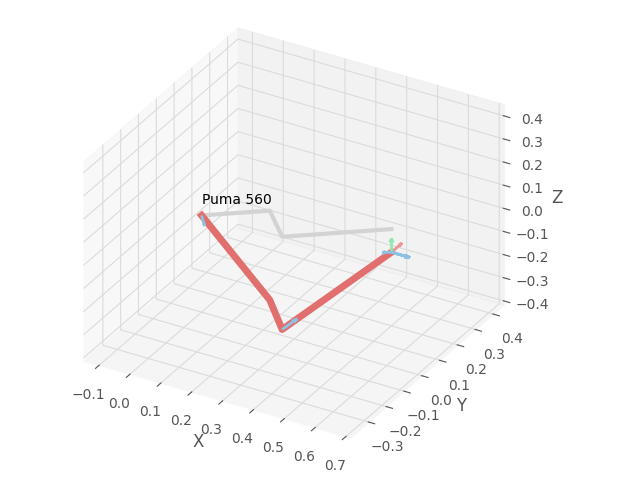

In [19]:
p560.plot(qt.q.T,100)

Other useful functions include the manipulator Jacobian which maps joint velocity to end-effector velocity expressed in the world frame

In [20]:
p560.jacob0(p560.qn)

array([[  0.1501,  0.01435,   0.3197,        0,        0,        0],
       [  0.5963,        0,        0,        0,        0,        0],
       [       0,   0.5963,    0.291,        0,        0,        0],
       [       0,        0,        0,   0.7071,        0,        1],
       [       0,        0,        0,        0,        0,        0],
       [       1,        0,        0,        0,        0,        0]])

Another way to consider robot kinematics is as a product of exponentials

In [21]:
tw, T0 = p560.twists()
tw

(-0 -0 -0; 0 0 1)
(0 -0 -0; 0 -1 6.1232e-17)
(0 -2.644e-17 -0.4318; 0 -1 6.1232e-17)
(-0.15005 -0.4521 0; 0 0 1)
(0.4318 -2.7683e-17 -0.4521; 0 -1 6.1232e-17)
(-0.15005 -0.4521 0; 0 0 1)


In [22]:
T0

   1           0           0           0.4521       
   0           1           0          -0.15005      
   0           0           1           0.4318       
   0           0           0           1            



where `tw` is a sequence of six twists that describe the joint axes in terms of a line of action and a screw pitch.  They are instances of the `Twist3` class which has a large number of methods. 